4.1 

$
\beta \sim N(0, I_3)\\
\sigma^2 \sim InverseGamma(5, 5)\\
Y|\beta, \sigma^2 \sim N(X\beta, \sigma^2I_T)
$

인 선형회귀 모델을 다볼록 임의보행(Random Walk) MH 기법으로 추정해보시오. (단, 블록은 $\theta_1=\beta, \theta_2=\sigma^2$ 으로 나누시오)

In [61]:
import pandas as pd
import numpy as np
from scipy.stats import norm, invgamma, multivariate_normal
from scipy.optimize import minimize
from scipy.differentiate import hessian

T=100
np.random.seed(0)
X=np.random.randn(T, 3)
beta_true=np.array([0.5, -0.5, 0.8])
sigma2_true=0.7
y= X @ beta_true + np.sqrt(sigma2_true) * np.random.randn(T)

def neg_log_posterior(params, X, y, a0=5.0, b0=5.0):
    beta   = params[:-1]
    z = params[-1]
    sigma2=np.exp(z)
    mu= X @ beta
    log_likelihood = norm.logpdf(y, loc=mu, scale=np.sqrt(sigma2)).sum()
    k=X.shape[1]
    log_prior_beta = multivariate_normal.logpdf(beta, mean=np.zeros(k), cov=np.eye(k))
    log_prior_sigma2 = invgamma.logpdf(sigma2, a=a0, scale=b0)
    return -(log_likelihood + log_prior_beta + log_prior_sigma2+ z)  # Jacobian 항목 z = log(sigma^2)

def get_optimal_theta(X, y, a0=5.0, b0=5.0):
    k = X.shape[1]
    # inital는 사전분포의 평균으로 설정
    initial_params = np.zeros(k + 1)
    initial_params[-1] = np.log(b0 / (a0 - 1)) if a0 > 1 else 1.0

    # 최적화 수행
    result = minimize(neg_log_posterior, initial_params, args=(X, y, a0, b0))
    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)
    return result.x

def get_hessian_cov(X, y, optimal_params, a0=5.0, b0=5.0, eps=1e-6):
    def f(th):
        th = np.asarray(th)
        m = th.shape[0]

        # 나머지 축 = 여러 점들
        rest_shape = th.shape[1:]
        if rest_shape == ():  # 단일점
            return -neg_log_posterior(th, X, y, a0, b0)

        # (m, k1, k2, ...) -> (prod, m)
        thr = th.reshape(m, -1).T   # (N, m), N=prod(rest_shape)
        vals = np.array([-neg_log_posterior(x, X, y, a0, b0) for x in thr])   # (N,)
        return vals.reshape(rest_shape)
    hess = hessian(f, np.asarray(optimal_params, dtype=float))
    hess_ddf = 0.5 * (hess.ddf + hess.ddf.T)  # 대칭화
    cov = np.linalg.inv(-hess_ddf)+eps*np.eye(hess_ddf.shape[0])
    return cov

optimal_params = get_optimal_theta(X, y)
print("Optimal parameters (beta and log_sigma^2):", optimal_params)
print('estimated sigma^2:', np.exp(optimal_params[-1]))
cov = get_hessian_cov(X, y, optimal_params, eps=0.0)
print("Covariance matrix from Hessian:", cov)

Optimal parameters (beta and log_sigma^2): [ 0.44541078 -0.55589951  0.84993544 -0.41943532]
estimated sigma^2: 0.6574179485970295
Covariance matrix from Hessian: [[ 6.22792083e-03  3.84624628e-04 -6.18986908e-04 -3.69836746e-05]
 [ 3.84624628e-04  6.72568749e-03  2.03277383e-04  6.17212566e-05]
 [-6.18986908e-04  2.03277383e-04  6.81674530e-03 -9.82741002e-05]
 [-3.69836746e-05  6.17212566e-05 -9.82741002e-05  1.81842599e-02]]


In [63]:
def rw_mh_block_sampler(X, y, inital_params, cov, burn_in, n_iter, a0=5.0, b0=5.0):
    k = X.shape[1]
    beta_current = inital_params[:-1]
    z_current = inital_params[-1]

    beta_list = []
    z_list = []
    for i in range(n_iter):
        # Block 1: beta sampling
        beta_cond_sigma2_cov= cov[:-1, :-1]-cov[:-1, -1][:, None] @ cov[-1, :-1][None, :]/cov[-1, -1]
        beta_proposal = multivariate_normal.rvs(mean=beta_current, cov=beta_cond_sigma2_cov)

        # p(beta_current | z_current, y)
        log_posterior_current = -neg_log_posterior(np.concatenate([beta_current, [z_current]]), X, y, a0, b0)
        # p(beta_proposal | z_current, y)
        log_posterior_proposal = -neg_log_posterior(np.concatenate([beta_proposal, [z_current]]), X, y, a0, b0)
        # q(beta_current | beta_proposal, z_current, y)
        log_proposal_current = multivariate_normal.logpdf(beta_current, mean=beta_proposal, cov=beta_cond_sigma2_cov)
        # q(beta_proposal | beta_current, z_current, y)
        log_proposal_proposal = multivariate_normal.logpdf(beta_proposal, mean=beta_current, cov=beta_cond_sigma2_cov)
        
        log_acceptance_ratio = (log_posterior_proposal + log_proposal_current) - (log_posterior_current + log_proposal_proposal)
        if np.log(np.random.rand()) < log_acceptance_ratio:
            beta_current = beta_proposal

        # Block 2: z sampling
        z_cov_cond_beta = cov[-1, -1]-cov[-1, :-1] @ np.linalg.inv(cov[:-1, :-1]) @ cov[:-1, -1]
        z_proposal = norm.rvs(loc=z_current, scale=np.sqrt(z_cov_cond_beta))

        log_posterior_current = -neg_log_posterior(np.concatenate([beta_current, [z_current]]), X, y, a0, b0)
        log_posterior_proposal = -neg_log_posterior(np.concatenate([beta_current, [z_proposal]]), X, y, a0, b0)
        log_proposal_current = norm.logpdf(z_current, loc=z_proposal, scale=np.sqrt(z_cov_cond_beta))
        log_proposal_proposal = norm.logpdf(z_proposal, loc=z_current, scale=np.sqrt(z_cov_cond_beta))

        log_acceptance_ratio = (log_posterior_proposal + log_proposal_current) - (log_posterior_current + log_proposal_proposal)
        if np.log(np.random.rand()) < log_acceptance_ratio:
            z_current = z_proposal

        if i >= burn_in:
            beta_list.append(beta_current)
            z_list.append(z_current)

    return np.array(beta_list), np.array(z_list)


beta_samples, z_samples = rw_mh_block_sampler(X, y, optimal_params, cov, burn_in=5000, n_iter=20000)
print("Posterior mean of beta:", beta_samples.mean(axis=0))
print("Posterior mean of sigma^2:", np.exp(z_samples).mean())


Posterior mean of beta: [ 0.44589926 -0.55459275  0.85363219]
Posterior mean of sigma^2: 0.6871197124353431


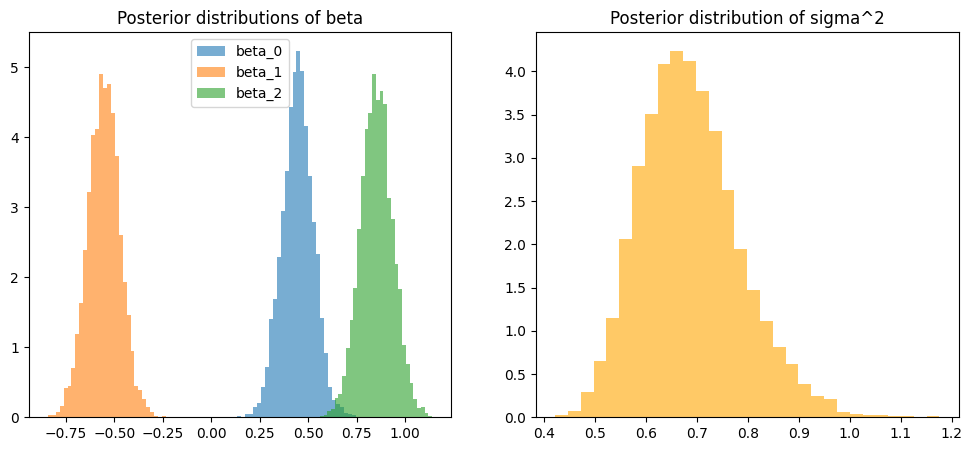

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(beta_samples.shape[1]):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'beta_{i}')
plt.title('Posterior distributions of beta')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(np.exp(z_samples), bins=30, density=True, alpha=0.6, color='orange')
plt.title('Posterior distribution of sigma^2')
plt.show()